In [1]:
import numpy as np

import astropy.units as u  
import astropy.constants as c
from astropy.coordinates import SkyCoord, Galactic, CartesianRepresentation

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib 

from itertools import product

from astropy.io import fits
from astropy.table import Table, join

import sys
import os
import tqdm

bayestar_path = '/uufs/astro.utah.edu/common/home/u1371365/dustmaps_data/bayestar/bayestar2019.h5'
from dustmaps.bayestar import BayestarQuery

### NEW 03-20: implement the 10pc resolution Vergely map into dustmaps ###
from dustmaps.vergely2022 import Vergely2022Query

import h5py
from dustapprox.models import PrecomputedModel

import emcee
import corner

In [2]:
CA_meta = Table(fits.open('../Data/230420_CAResiduals/CA_meta.fits')[1].data)
CAresdir = '../Data/230420_CAResiduals/'
starhorsepath = '/uufs/chpc.utah.edu/common/home/sdss/dr17/env/APOGEE_STARHORSE/APOGEE_DR17_EDR3_STARHORSE_v2.fits'
starhorse = Table.read(starhorsepath, hdu = 1)
starhorse = starhorse['APOGEE_ID', 'dist16', 'dist50', 'dist84', 'AV16', 'AV50', 'AV84']

CA_meta = join(CA_meta, starhorse, keys = 'APOGEE_ID', join_type = 'left')

In [3]:
### Dustmap coordinates
distance = np.linspace(0, 1000, 200)


l0, b0 = (163., -8.0)
l_ = np.linspace(l0 - 9., l0 + 9., 200)
b_ = np.linspace(b0 - 9., b0 + 9., 200)
l, b, d = np.meshgrid(l_, b_, distance)
print(l.shape)

coords = SkyCoord(l*u.deg, b*u.deg,
                  distance=distance*u.pc, frame='galactic')

(200, 200, 200)


In [4]:
lambda0 = 15272.42 
sigma0 = 1.15

def get_wavs(hdulist = None, rv = 0):
    if hdulist is None:
        CRVAL1 = 4.179
        CDELT1 = 6e-06
        LEN = 8575
    else:
        header = hdulist[1].header
        CRVAL1 = header['CRVAL1']
        CDELT1 = header['CDELT1']
        LEN = header['NAXIS1']
        
    wavs = np.power(10, CRVAL1 + CDELT1 * np.arange(LEN))
    wavs = wavs * (1 + rv / 3e5) # allows for shifting to observed frame from rest frame
    return wavs

wavs = get_wavs()
window = (wavs > lambda0 -10) & (wavs < lambda0 + 10)
window_inds = np.where(window)[0]
wavs_window = wavs[window]
window_mask = (wavs_window < lambda0) - 5 | (wavs_window > lambda0 + 5)

def dopplershift(v, lambda0 = lambda0):
     return (lambda0 * u.Angstrom * (c.c + v * u.km / u.s) / c.c).to(u.Angstrom).value

In [5]:
def get_ca_res(fname):
    return str(CAresdir + str(fname))

def select_stars(tab, l0, b0, radius = 1):
    cond = np.sqrt((tab['GLON'] - l0)**2 + (tab['GLAT'] - b0)**2) < radius
    return np.where(cond)[0]

In [6]:
loff = 1
boff = 1
l_cen, b_cen, = (163 + loff , -8.4 + boff)
s= select_stars(CA_meta, l_cen, b_cen, radius = .25)
s1 = select_stars(CA_meta, l_cen +1 , b_cen +1 , radius = .23)
s2 = select_stars(CA_meta, l_cen -1 , b_cen -1 , radius = .23)
s3 = select_stars(CA_meta, l_cen - 2, b_cen - 2, radius = 0.23)

In [7]:
def find_nearest(ll, bb):
    l_sel = l_
    b_sel = b_

    return np.argmin(np.abs(l_sel - ll)), np.argmin(np.abs(b_sel - bb))

def find_nearest_dist(d):
    return np.argmin(np.abs(distance[:, np.newaxis] - d), axis = 0)


def dAV_dd(l0, b0, bin_edges):
    l_ind, b_ind = find_nearest(l0, b0)
    sightline = np.copy(vergely[b_ind, l_ind, :]) #needs to be b then l then :

    d_min, d_max = bin_edges

    extinction = sightline[(distance > d_min) & (distance < d_max)]
    return np.sum(extinction )

def dAV_dd_star(l0, b0, bin_edges, distances):
    l_ind, b_ind = find_nearest(l0, b0)
    d_min, d_max = bin_edges
    sightline = np.copy(vergely[b_ind, l_ind, :])
    sightline[(distance < d_min) | (distance > d_max)] = 0
    sightline_av = (np.cumsum(sightline)) 
    d_ind = find_nearest_dist(distances)

    return np.nanmedian(sightline_av[d_ind])

def Differential_Amplitude(dAv_dd, dd):
    if type(dd) == int:
        return  0.024 * dAv_dd * dd  # 1/(np.sqrt(2 * np.pi) * sigma0) * 102e-3 * dAv_dd * dd
    elif dd.shape == dAv_dd.shape:
        return 0.024 * dAv_dd * dd 
    else:
        return 0.024 * dAv_dd * dd[np.newaxis, :]

        #  return 0.024 * dAv_dd * dd[:, np.newaxis]

def dAV_dd_array(l, b, bins, star_dist, dmap_dist = distance):
    l_ind, b_ind = find_nearest(l, b)
    verg_sightline = np.copy(vergely[b_ind, l_ind, :]) 
    dAVdd = np.zeros(len(bins)-1)
    dAVdd_all = np.zeros(len(bins)-1)
    dAVdd_mask = np.zeros(len(bins-1))
    for i in range(len(dAVdd)):
        bin_min, bin_max = bins[i], bins[i+1]
        if bin_min < star_dist:
            dist_max = bin_max
            if bin_max >= star_dist:
                dist_max = star_dist
        else:
            dist_max = -np.inf

            
        dAVdd[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= dist_max)])

        dAVdd_all[i] = np.sum(verg_sightline[(dmap_dist > bin_min) & (dmap_dist <= bin_max)])

    dAVdd_mask = (dAVdd == 0).astype(bool)
    return dAVdd, dAVdd_all

In [8]:
signals = np.zeros((len(CA_meta), len(window_inds)))
signal_errs = np.zeros((len(CA_meta), len(window_inds)))

for i in range(len(CA_meta)):
    star = CA_meta[i]
    res_hdul = fits.open(get_ca_res(star['FILE']))
    signals[i, :] = res_hdul[1].data[window]
    signal_errs[i, :] = res_hdul[2].data[window]

In [9]:
sig_diff = np.zeros((len(CA_meta), len(CA_meta), len(window_inds)))
angsep = np.zeros((len(CA_meta), len(CA_meta)))
distsep = np.zeros((len(CA_meta), len(CA_meta)))
for i in range(len(CA_meta)):
    for j in range(len(CA_meta)): 
        angsep[i, j] = np.sqrt((CA_meta['GLON'][i]-CA_meta['GLON'][j])**2 + 
                               (CA_meta['GLAT'][i] - CA_meta['GLAT'][j])**2)
        distsep[i, j] = np.sqrt((CA_meta['DIST'][i] - CA_meta['DIST'][j])**2)
        sig_diff[i, j, :] = signals[i, :] - signals[j, :]

# distsep

/tmp/ipykernel_3144570/2640359535.py:9: RuntimeWarning: invalid value encountered in subtract
  sig_diff[i, j, :] = signals[i, :] - signals[j, :]


In [10]:
distsep_ = np.triu(distsep)
distsep_[distsep_ == 0.0]
distsep_sort = np.argsort(distsep_)


In [11]:
sig_diff.shape

(1494, 1494, 95)

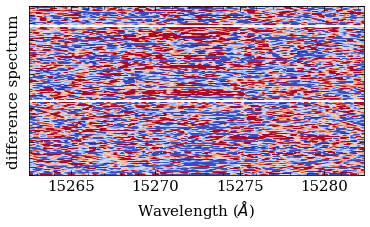

In [16]:
fig, ax= plt.subplots()
sig_diff_image = sig_diff[distsep_sort[0], distsep_sort[1], :].reshape(-1, 95)
sig_diff_image = sig_diff_image[(np.all(np.isnan(sig_diff_image) == False, axis = 1) & (np.all(sig_diff_image == 0.0, axis = 1)==False)), :]
resamp = np.arange(0, len(sig_diff_image), 1000)

extent = (np.min(wavs[window]), np.max(wavs[window]), 0, 1)
ax.imshow(sig_diff_image, cmap = 'coolwarm', vmin = -0.005, vmax = 0.005, extent = extent, aspect = 10)
ax.set_xlabel("Wavelength ($\AA$)")
ax.set_ylabel("difference spectrum")
ax.set_yticklabels('')
plt.show()

In [13]:
np.where(np.isnan(sig_diff_image ))

(array([], dtype=int64), array([], dtype=int64))

In [14]:
sig_diff_image

array([[-0.02434028, -0.02686346, -0.00443236, ..., -0.0360538 ,
        -0.0200344 , -0.02033957],
       [-0.00336467, -0.00625181, -0.0058565 , ...,  0.01722319,
        -0.00758224, -0.02164935],
       [ 0.00482001,  0.00881345, -0.01162161, ..., -0.006481  ,
        -0.00026755, -0.00484839],
       ...,
       [ 0.0161218 , -0.04959037, -0.05632671, ..., -0.04170722,
        -0.02630632, -0.00444759],
       [-0.03627394, -0.07164762, -0.0510581 , ...,  0.02960803,
         0.04099038,  0.02898779],
       [ 0.01823072,  0.04718994,  0.02065764, ..., -0.04510571,
        -0.05821995, -0.03284717]])